## Задача 5. Оценить поток момента импульса через подстилающую поверхность по данным реанализа

In [27]:
from datetime import datetime

import cartopy.crs as ccrs
import netCDF4 as nc
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

In [28]:
filename = 'p-levels_t_u_v_geopotential_10.nc'
dataset = nc.Dataset(filename)
print(dataset.variables)

{'longitude': <class 'netCDF4._netCDF4.Variable'>
float32 longitude(longitude)
    units: degrees_east
    long_name: longitude
unlimited dimensions: 
current shape = (1440,)
filling on, default _FillValue of 9.969209968386869e+36 used, 'latitude': <class 'netCDF4._netCDF4.Variable'>
float32 latitude(latitude)
    units: degrees_north
    long_name: latitude
unlimited dimensions: 
current shape = (721,)
filling on, default _FillValue of 9.969209968386869e+36 used, 'level': <class 'netCDF4._netCDF4.Variable'>
int32 level(level)
    units: millibars
    long_name: pressure_level
unlimited dimensions: 
current shape = (3,)
filling on, default _FillValue of -2147483647 used, 'time': <class 'netCDF4._netCDF4.Variable'>
int32 time(time)
    units: hours since 1900-01-01 00:00:00.0
    long_name: time
    calendar: gregorian
unlimited dimensions: 
current shape = (30,)
filling on, default _FillValue of -2147483647 used, 'z': <class 'netCDF4._netCDF4.Variable'>
int16 z(time, level, latitude, l

In [29]:
lats = dataset['latitude'][:]
lats_rad = (lats / 180) * np.pi

lons = dataset['longitude'][:]
lons_rad = (lons / 180) * np.pi

time = dataset['time'][:]
p_level = dataset['level'][:]

data_u = dataset['u'][:]
data_v = dataset['v'][:]
data_t = dataset['t'][:]
data_z = dataset['z'][:]

In [30]:
filename2 = 'adaptor.mars.internal-1670423241.6391394-30342-7-a4df4ed6-7d0a-44fd-805d-5e72cf65afeb.nc'
# zust - Friction velocity
# z - Geopotential
# metss - Mean eastward turbulent surface stress
# mngwss - Mean northward gravity wave surface stress
# sp - Surface pressure
dataset2 = nc.Dataset(filename2)
print(dataset2.variables)

{'longitude': <class 'netCDF4._netCDF4.Variable'>
float32 longitude(longitude)
    units: degrees_east
    long_name: longitude
unlimited dimensions: 
current shape = (1440,)
filling on, default _FillValue of 9.969209968386869e+36 used, 'latitude': <class 'netCDF4._netCDF4.Variable'>
float32 latitude(latitude)
    units: degrees_north
    long_name: latitude
unlimited dimensions: 
current shape = (721,)
filling on, default _FillValue of 9.969209968386869e+36 used, 'time': <class 'netCDF4._netCDF4.Variable'>
int32 time(time)
    units: hours since 1900-01-01 00:00:00.0
    long_name: time
    calendar: gregorian
unlimited dimensions: 
current shape = (30,)
filling on, default _FillValue of -2147483647 used, 'zust': <class 'netCDF4._netCDF4.Variable'>
int16 zust(time, latitude, longitude)
    scale_factor: 1.2953445576170568e-05
    add_offset: 0.43479181423025204
    _FillValue: -32767
    missing_value: -32767
    units: m s**-1
    long_name: Friction velocity
unlimited dimensions: 
c

In [31]:
data_sp = dataset2['sp'][:]
data_metss = dataset2['metss'][:]
data_mngwss = dataset2['mngwss'][:]

g = 9.80665
a = 6371 * 10**3
omega = 1.995 * (10 ** -7)

data_zh = dataset2['z'][:] / g

In [38]:
def get_derivative(x, y):
    if len(y.shape) == 3:
        first_el = np.expand_dims((y[:, :, 1] - y[:, :, 0]) / (x[1] - x[0]), axis=2)
        last_el =  np.expand_dims((y[:, :, -1] - y[:, :, -2]) / (x[-1] - x[-2]), axis=2)
        dy = np.concatenate((first_el, (y[:, :, 2:] - y[:, :, :-2]) / (x[2:] - x[:-2]), last_el), axis=2)
    elif len(y.shape) == 1:
        first_el = y[0] / (x[1] - x[0])
        last_el = y[-1] / (x[-1] - x[-2])
        dy = np.append(first_el, (y[ 2:] - y[:-2]) / (x[2:] - x[:-2]))
        dy = np.append(dy, last_el)
    elif len(y.shape) == 2:
        first_el = np.expand_dims((y[:, 1] - y[:, 0]) / (x[1] - x[0]), axis=1)
        last_el =  np.expand_dims((y[:, -1] - y[:, -2]) / (x[-1] - x[-2]), axis=1)
        dy = np.concatenate((first_el, (y[:, 2:] - y[:, :-2]) / (x[2:] - x[:-2]), last_el), axis=1)
    else:
        dy = None
    return dy

$$ \frac{\partial }{\partial t} \Bigg(\overline{\overline{p_s M}^\lambda}^\sigma\Bigg)=-\frac{1}{a \cdot cos\varphi}\frac{\partial }{\partial \varphi}\Bigg(\overline{\overline{p_s M \cdot cos\varphi \cdot v}^\lambda}^\sigma\Bigg) - a g \cos\varphi\Bigg[\overline{p_s \frac{\partial z_s}{\partial x}}^\lambda + \overline{\tau_{x, p}}^\lambda\Bigg]$$
 
$$ M = a\cdot \cos\varphi(\Omega\cdot cos\varphi + u)$$
$$\frac{\partial}{\partial x} = \frac{\partial}{a\cdot \cos\varphi \cdot \partial\lambda}$$
$g = 9.80665, a = 6371 \cdot 10^3, \Omega = 1.995 \cdot (10 ^ {-7})$
 
### Notation:

$ \varphi $ - lats <br>
$ \lambda $ - lons <br>
$ p_s $ - data_sp (surface pressure) <br>
$ \tau_{x, p} $ - data_mngwss (mean northward gravity wave surface stress) <br>
$ \frac{\partial }{\partial x} $ = get_derivative(x, )<br>


In [ ]:
# %%time
cos_lats_rad = np.cos(lats_rad)
omega_cos_lats_rad = omega * cos_lats_rad
u_plus_omega_cos_lats_rad = np.array([(data_utp.T + omega_cos_lats_rad).T for data_ut in data_u for data_utp in data_ut]).reshape(data_u.shape)
M = a * np.array([(utp.T * cos_lats_rad).T for ut in u_plus_omega_cos_lats_rad for utp in ut]).reshape(u_plus_omega_cos_lats_rad.shape)
M_v = M * data_v
cos_lats_rad_sp = np.array([(el.T * cos_lats_rad).T for el in data_sp])
dy = np.array([M_v[:, p_i, :, :] * cos_lats_rad_sp for p_i in range(M.shape[1])]).reshape(M.shape)
dy = np.mean(dy, axis=3)
dy = np.mean(dy, axis=1)
first_component = -1 / (a * np.cos(lats_rad)) * get_derivative(lats_rad, dy)

second_component = -g * data_sp * get_derivative(lons_rad, data_zh)
second_component_lam_mean = np.mean(second_component, axis=2)


third_component = a * g * np.array([(el.T * cos_lats_rad).T for el in data_mngwss])
third_component_lam_mean = np.mean(third_component, axis=2)

d_momentum = first_component + second_component_lam_mean + third_component_lam_mean

In [62]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] -= ret[:-n]
    res = ret[n - 1:] / n
    res = np.concatenate((np.array([res[0]] * (n - 1)), res))
    return res

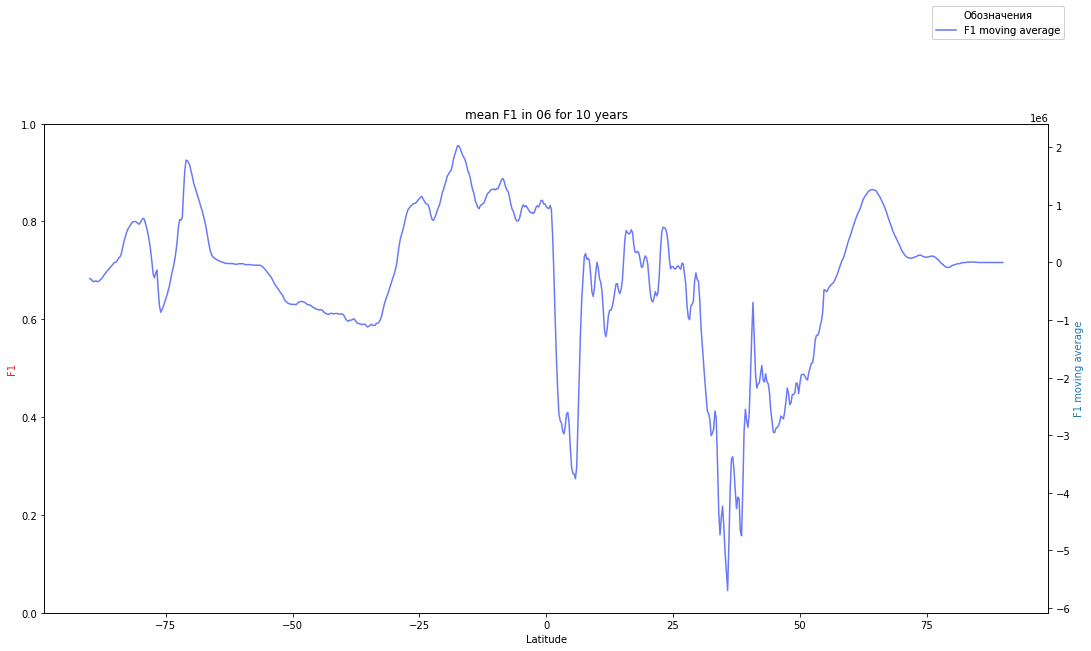

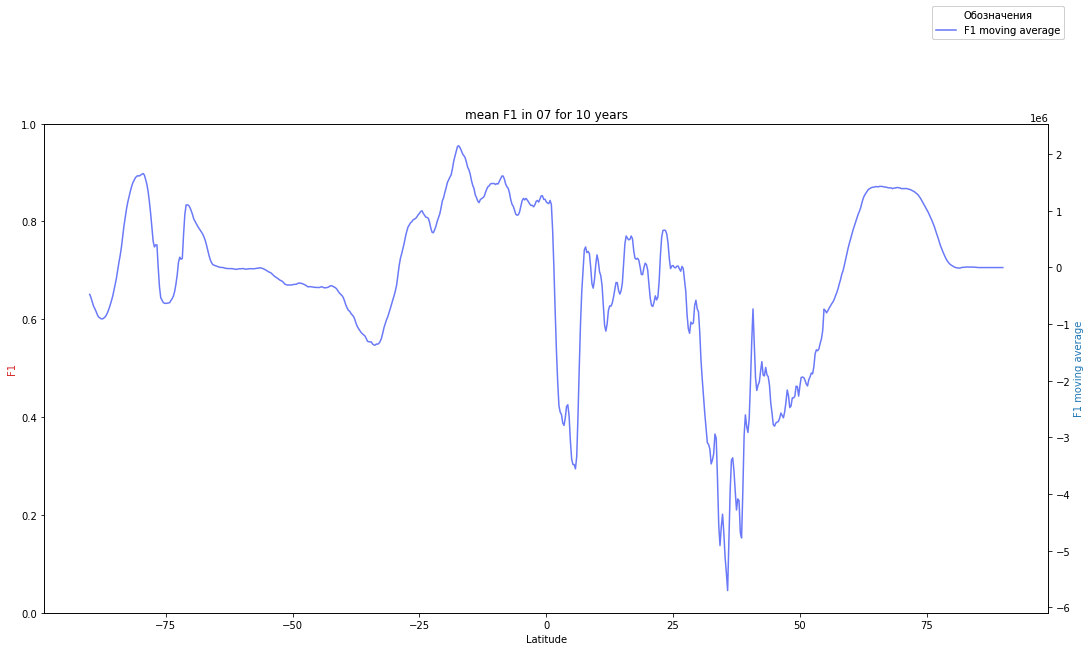

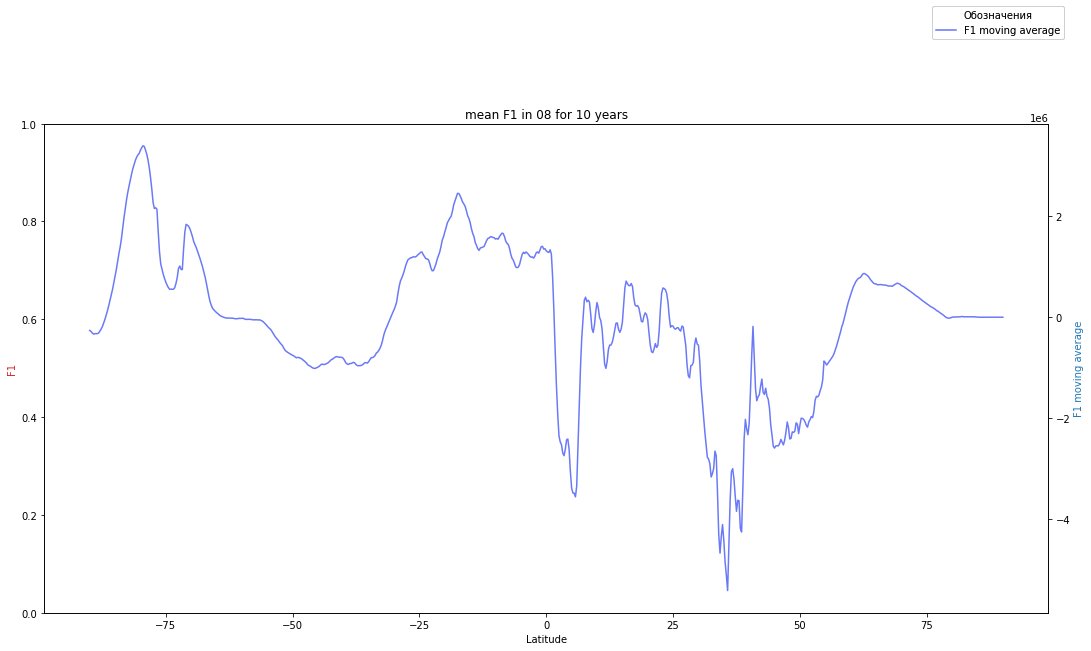

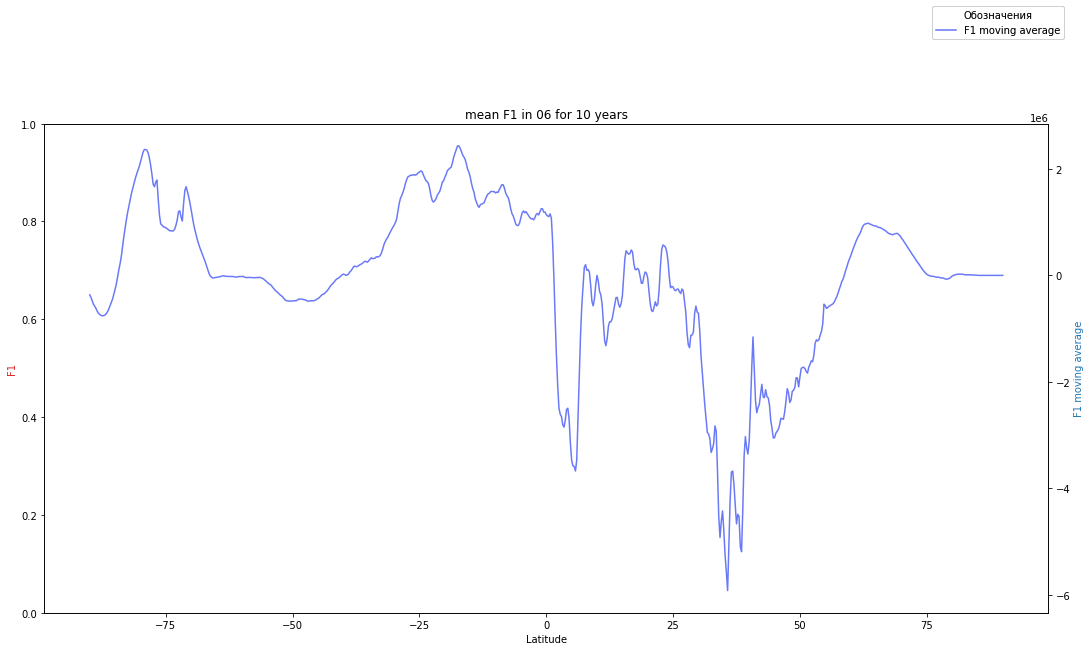

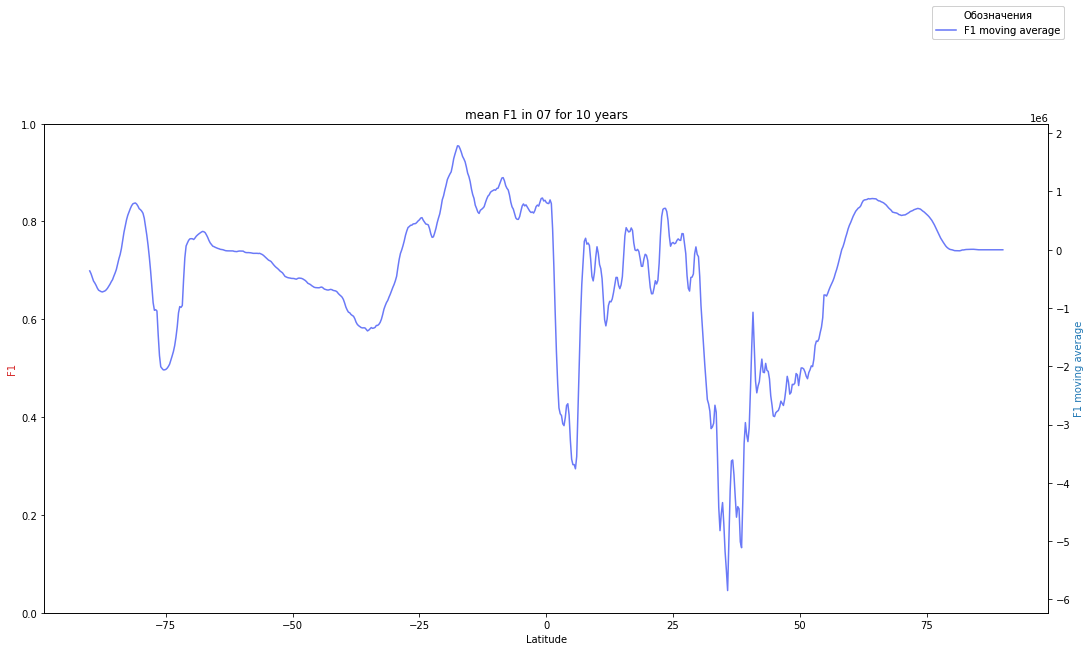

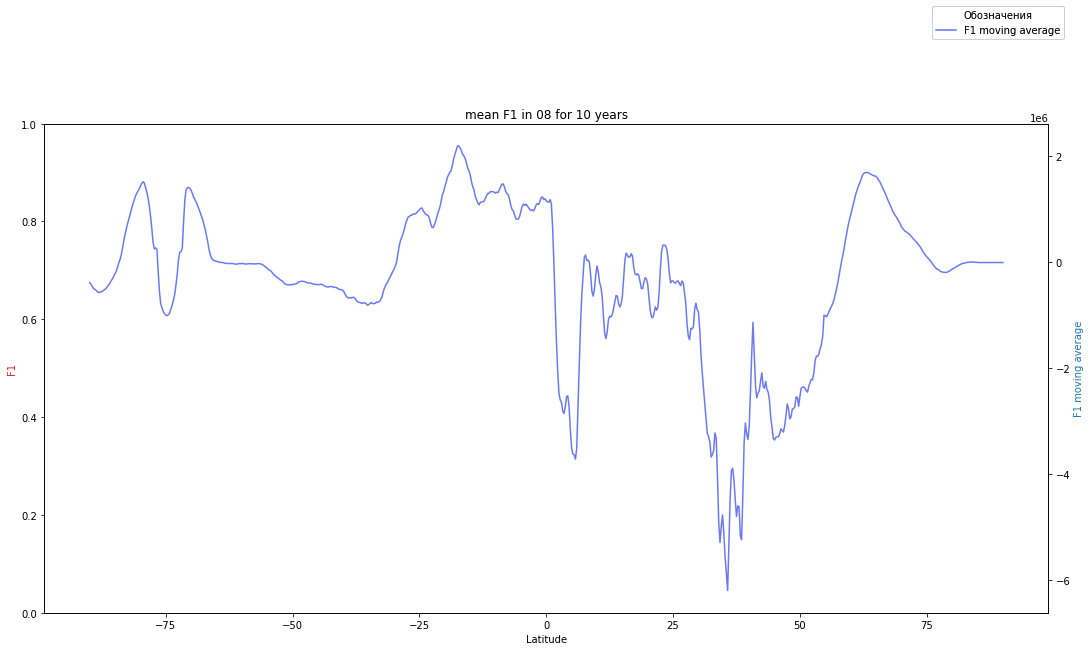

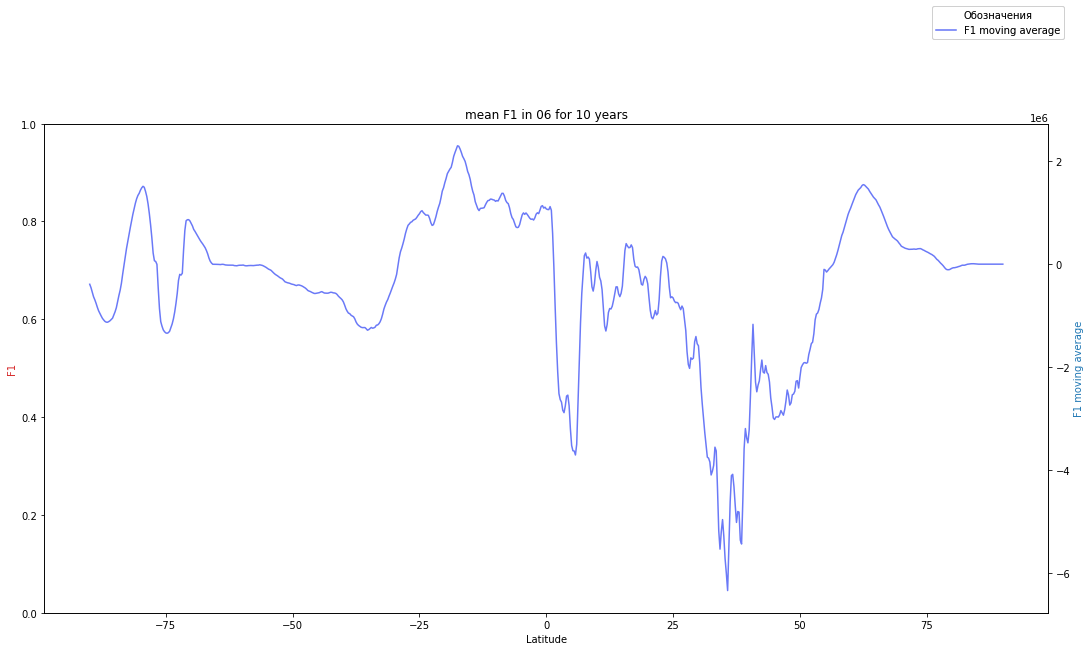

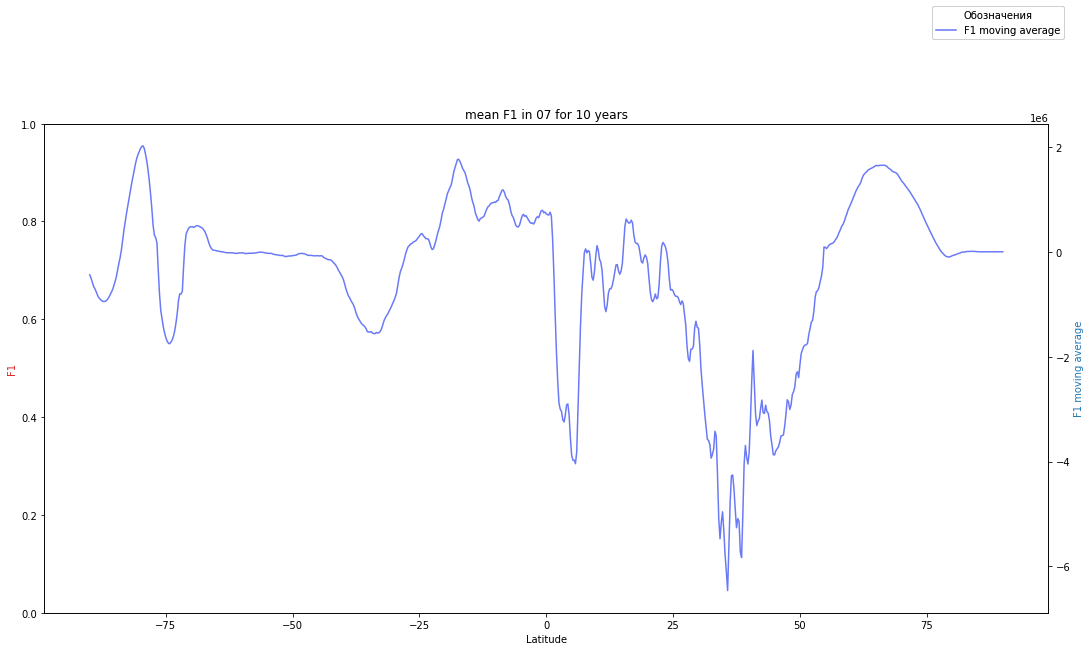

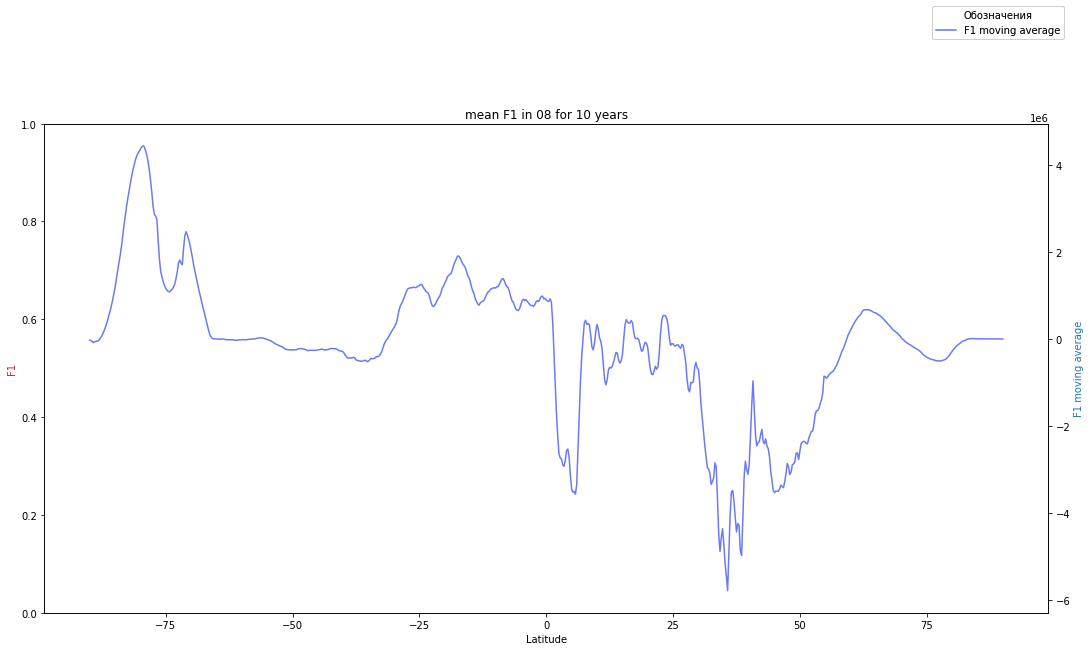

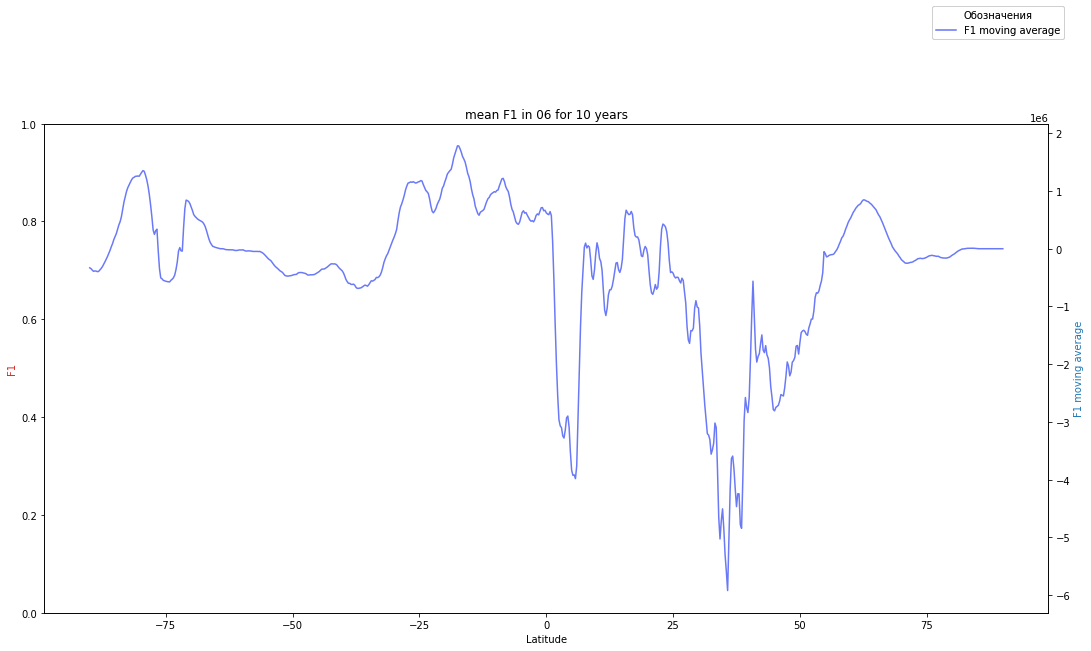

In [71]:
data_x2 = second_component_lam_mean[::3]
for t_i in range(10):
    
    f = plt.figure(figsize = (18, 9))
    ax1 = f.add_subplot()
    ax1.set_xlabel('Latitude')
    ax1.set_ylabel('F1', color='tab:red')
    ax2 = ax1.twinx()
    ax2.set_ylabel('F1 moving average', color='tab:blue')
    
    data_lines = []
#     d, = ax1.plot(lats, data_x2[t_i], color='xkcd:darkblue', label='F1')
#     data_lines.append(d)
    
    d, = ax2.plot(lats, moving_average(data_x2[t_i], 20), color='xkcd:cornflower', label='F1 moving average')
    data_lines.append(d)
    
    l = ax1.legend(handles=data_lines, bbox_to_anchor=(0.95, 1.25), loc=9, title='Обозначения')
    ax1.add_artist(l)
    
    delta_epoch = datetime(1970, 1, 1, 0, 0, 0) - datetime(1900, 1, 1, 0, 0, 0)
    date = datetime.fromtimestamp(time[t_i] * 3600) - delta_epoch
    plt.title(f'mean F1 in {date.strftime("%m")} for 10 years')
    plt.show()

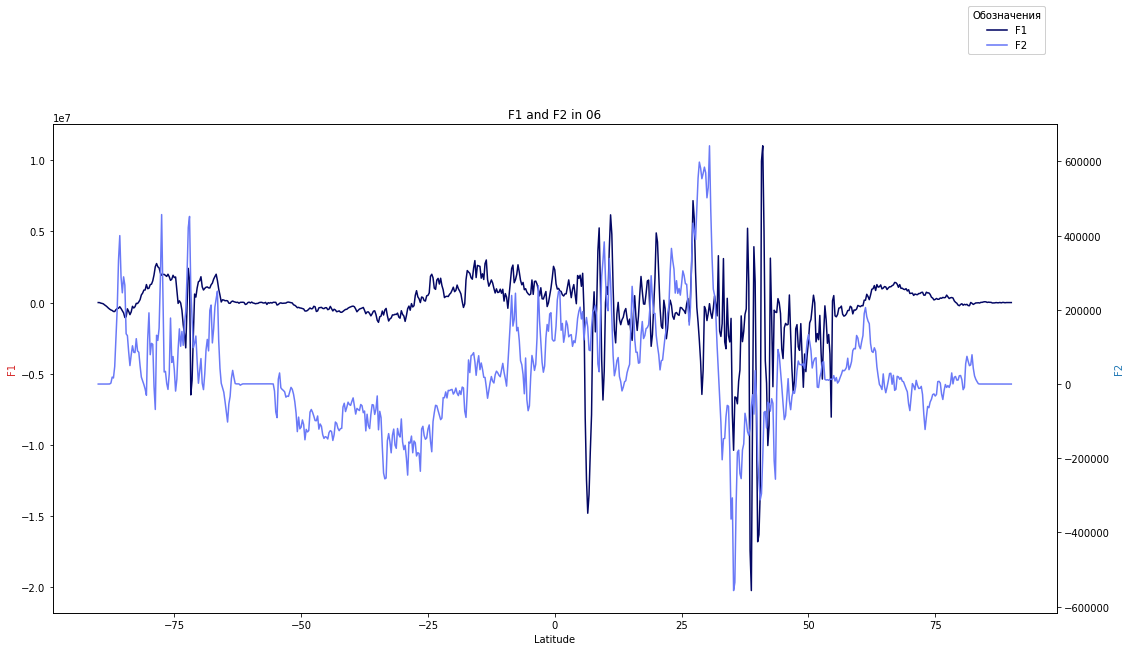

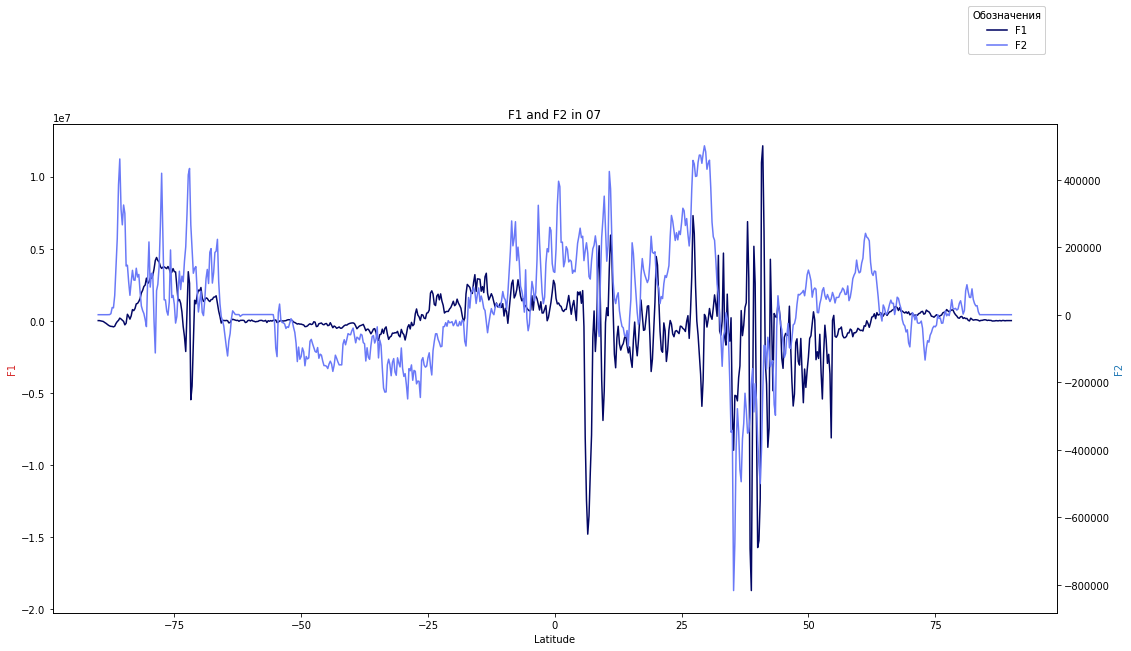

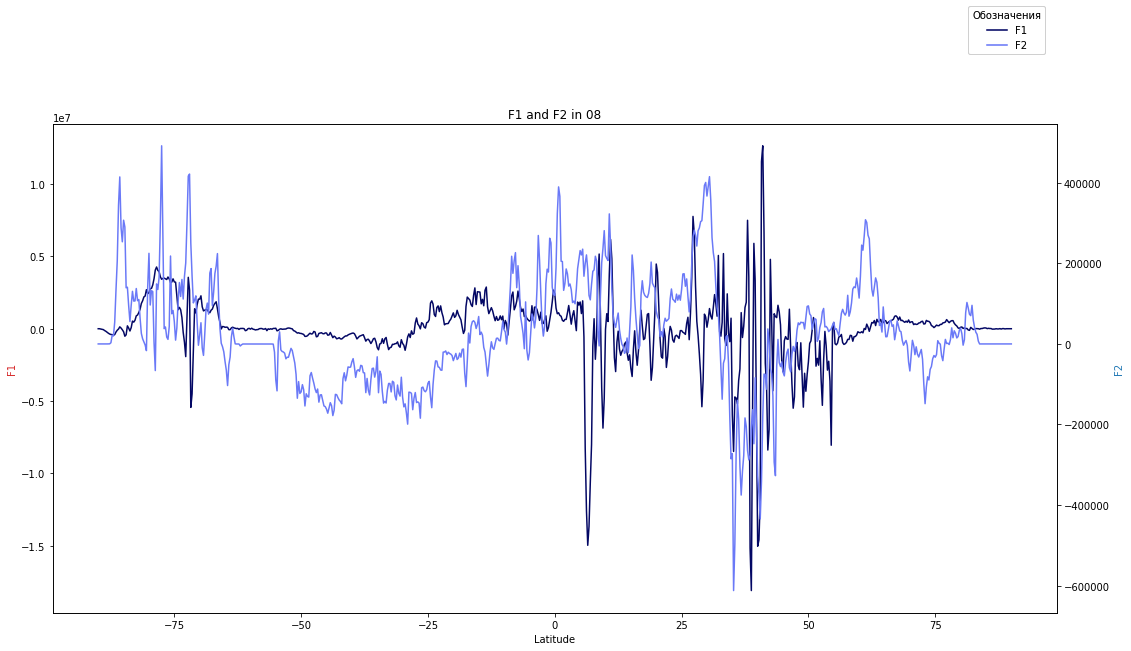

In [68]:
for t_i in range(3):
    data_x_2 = np.mean(second_component_lam_mean[t_i::3], axis=0)
    data_x_3 = np.mean(third_component_lam_mean[t_i::3], axis=0)
    f = plt.figure(figsize = (18, 9))
    ax1 = f.add_subplot()
    ax1.set_xlabel('Latitude')
    ax1.set_ylabel('F1', color='tab:red')
    ax2 = ax1.twinx()
    ax2.set_ylabel('F2', color='tab:blue')
    
    data_lines = []
    d, = ax1.plot(lats, data_x_2, color='xkcd:darkblue', label='F1')
    data_lines.append(d)
    
    d, = ax2.plot(lats, data_x_3, color='xkcd:cornflower', label='F2')
    data_lines.append(d)
    
    l = ax1.legend(handles=data_lines, bbox_to_anchor=(0.95, 1.25), loc=9, title='Обозначения')
    ax1.add_artist(l)
    
    delta_epoch = datetime(1970, 1, 1, 0, 0, 0) - datetime(1900, 1, 1, 0, 0, 0)
    date = datetime.fromtimestamp(time[t_i] * 3600) - delta_epoch
    plt.title(f'F1 and F2 in {date.strftime("%m")}')
    plt.show()

In [ ]:
for t_i in range(3):
    data_x_2 = np.mean(second_component_lam_mean[t_i::3], axis=0)
    data_x_3 = np.mean(third_component_lam_mean[t_i::3], axis=0)
    f = plt.figure(figsize = (18, 9))
    ax1 = f.add_subplot()
    ax1.set_xlabel('Latitude')
#     ax1.set_ylabel('F1', color='tab:red')
    
    data_lines = []
    d, = ax1.plot(lats, data_x_2, color='xkcd:darkblue', label='F1')
    data_lines.append(d)
    
    d, = ax1.plot(lats, data_x_3, color='xkcd:cornflower', label='F2')
    data_lines.append(d)
    
    l = ax1.legend(handles=data_lines, bbox_to_anchor=(0.95, 1.25), loc=9, title='Обозначения')
    ax1.add_artist(l)
    
    delta_epoch = datetime(1970, 1, 1, 0, 0, 0) - datetime(1900, 1, 1, 0, 0, 0)
    date = datetime.fromtimestamp(time[t_i] * 3600) - delta_epoch
    plt.title(f'F1 and F2 in {date.strftime("%m")}')
    plt.show()

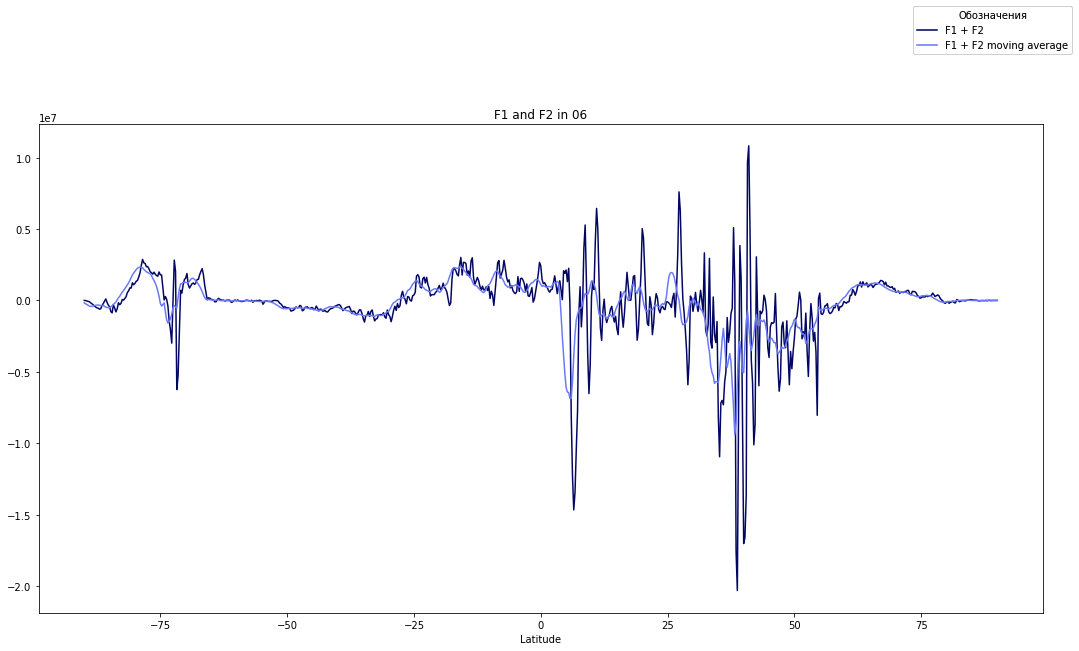

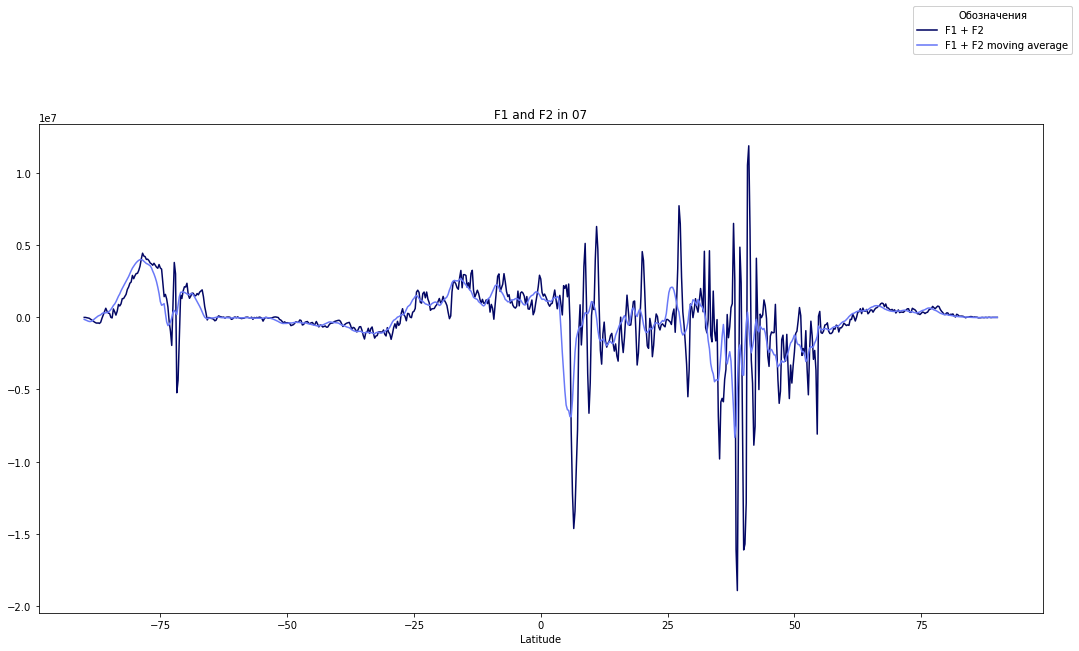

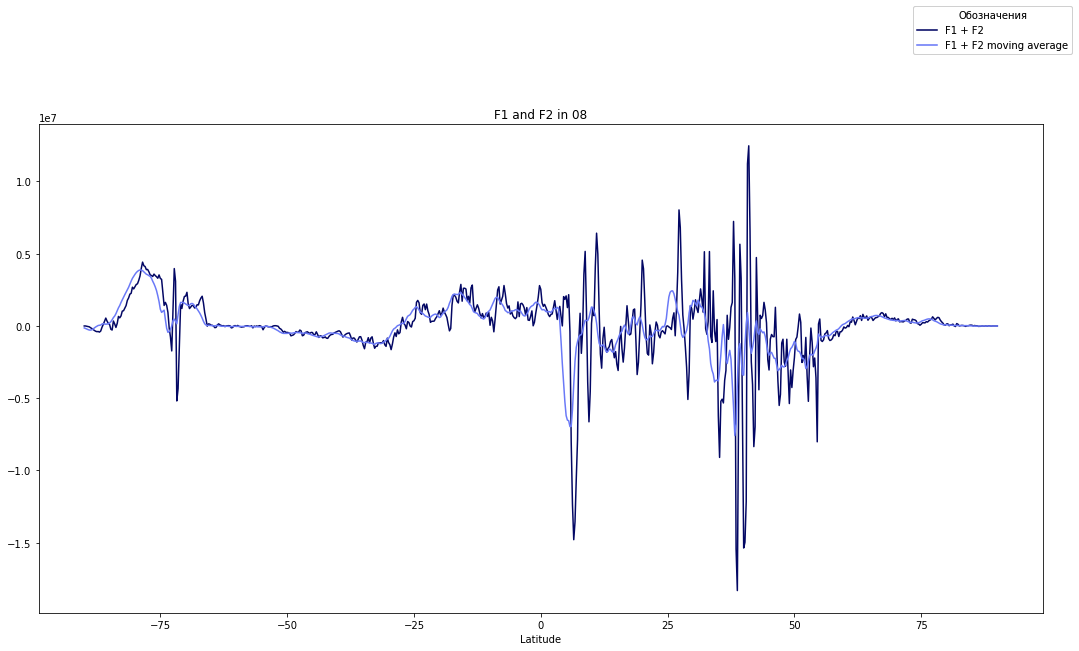

In [74]:
for t_i in range(3):
    data_x_2 = np.mean(second_component_lam_mean[t_i::3], axis=0)
    data_x_3 = np.mean(third_component_lam_mean[t_i::3], axis=0)
    f = plt.figure(figsize = (18, 9))
    ax1 = f.add_subplot()
    ax1.set_xlabel('Latitude')
#     ax1.set_ylabel('F1', color='tab:red')
    
    data_lines = []
    d, = ax1.plot(lats, data_x_2 + data_x_3, color='xkcd:darkblue', label='F1 + F2')
    data_lines.append(d)
    
    d, = ax1.plot(lats, moving_average(data_x_2 + data_x_3, 10), color='xkcd:cornflower', label='F1 + F2 moving average')
    data_lines.append(d)
    
    l = ax1.legend(handles=data_lines, bbox_to_anchor=(0.95, 1.25), loc=9, title='Обозначения')
    ax1.add_artist(l)
    
    delta_epoch = datetime(1970, 1, 1, 0, 0, 0) - datetime(1900, 1, 1, 0, 0, 0)
    date = datetime.fromtimestamp(time[t_i] * 3600) - delta_epoch
    plt.title(f'F1 and F2 in {date.strftime("%m")}')
    plt.show()

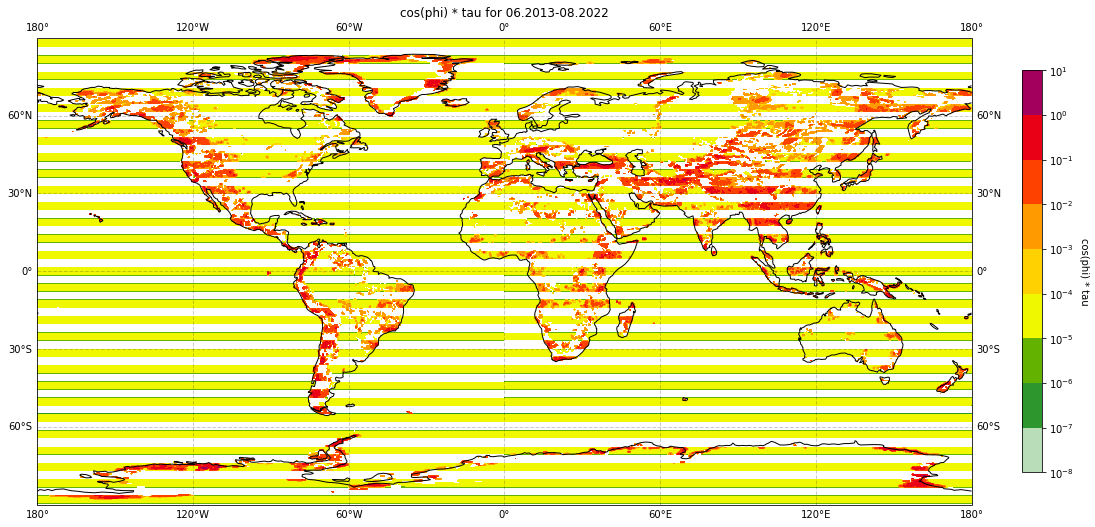

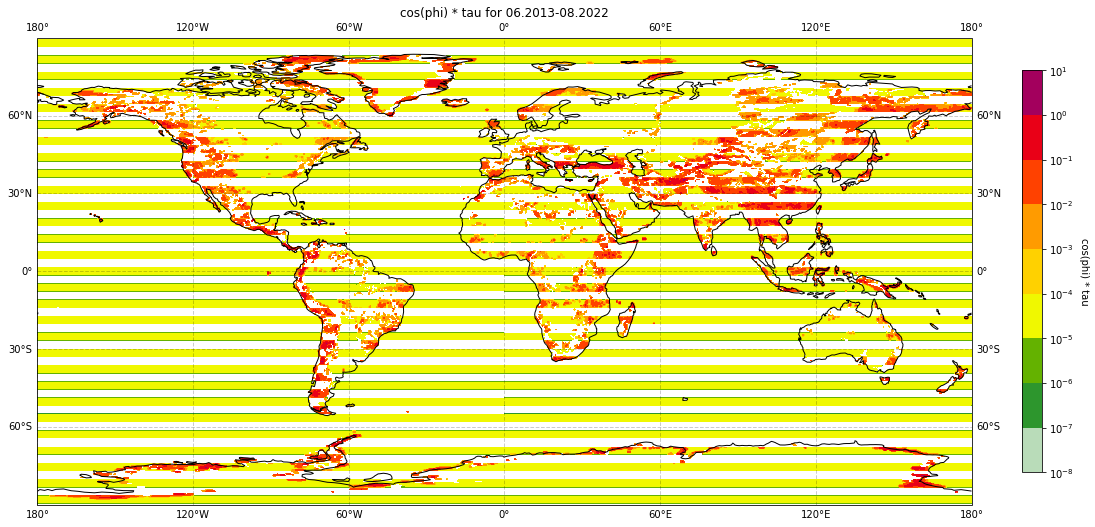

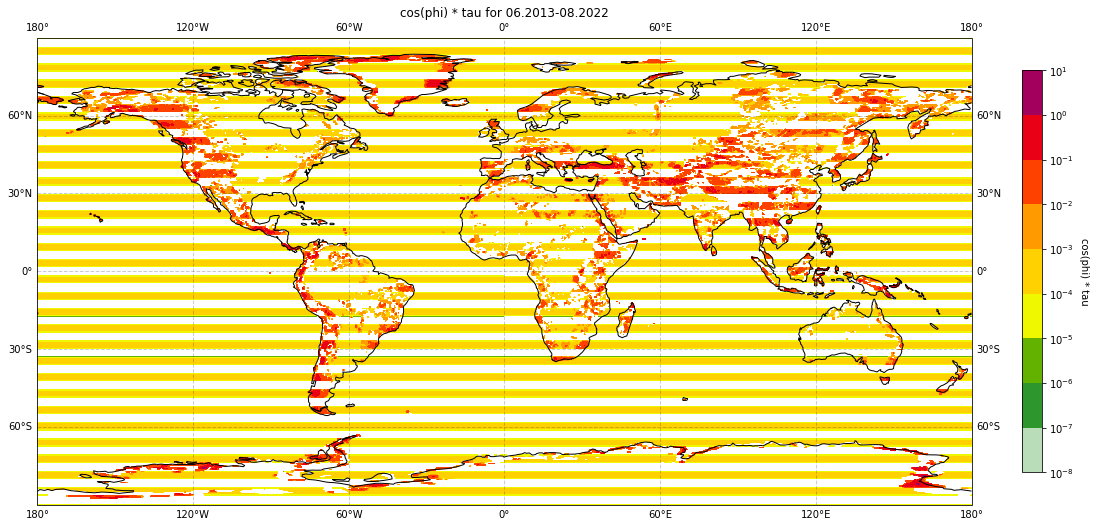

In [60]:
from matplotlib.colors import LogNorm
from matplotlib import pyplot, ticker

data_cos_mngwss = np.array([(el.T * cos_lats).T for el in data_mngwss])
# data_cos_mngwss += abs(data_cos_mngwss.min())
data_crs = ccrs.PlateCarree()

newcmp = LinearSegmentedColormap.from_list('', ['white', 'green', 'yellow', 'orange', 'red', 'purple'])

for t_i in range(3):
    el = data_cos_mngwss[t_i, :, :]
    f = plt.figure(figsize = (18, 9))
    f.patch.set_facecolor('white')

    ax = plt.axes(projection = data_crs)
    plt.contourf(lons, lats, el,
                 locator=ticker.LogLocator(),
                 transform=data_crs, cmap=newcmp)
    ax.coastlines()

    gl = ax.gridlines(crs = ccrs.PlateCarree(), draw_labels = True,
                      linewidth = 1, color = 'black', alpha = 0.2, linestyle = '--')

    cbar = plt.colorbar(fraction = 0.02)
    cbar.ax.get_yaxis().labelpad = 15
    cbar.set_label(name, rotation = 270)

    delta_epoch = datetime(1970, 1, 1, 0, 0, 0) - datetime(1900, 1, 1, 0, 0, 0)
    date_start = datetime.fromtimestamp(time[0] * 3600) - delta_epoch
    date_end = datetime.fromtimestamp(time[-1] * 3600) - delta_epoch
    plt.title(f'{name} for {date_start.strftime("%m.%Y")}-{date_end.strftime("%m.%Y")}')

    plt.show()

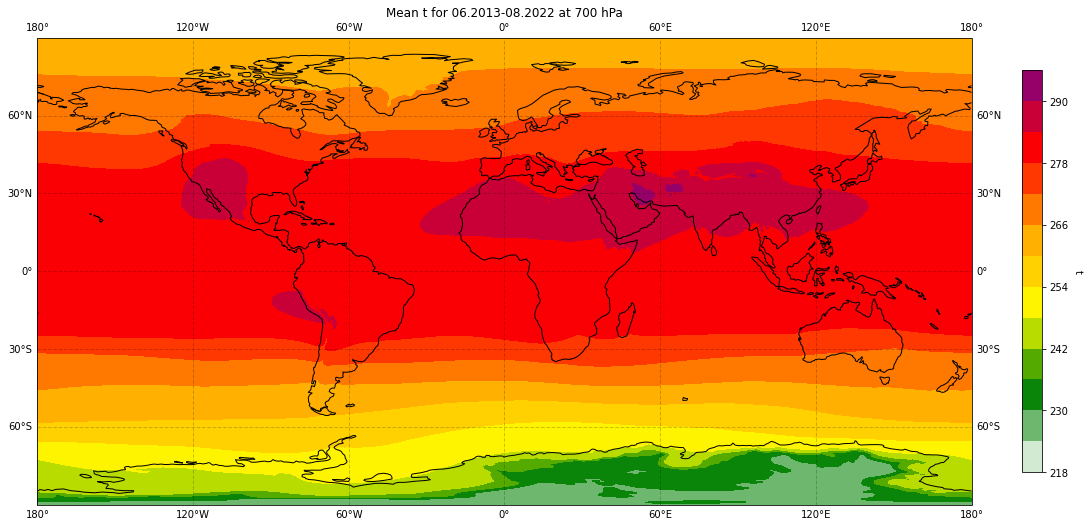

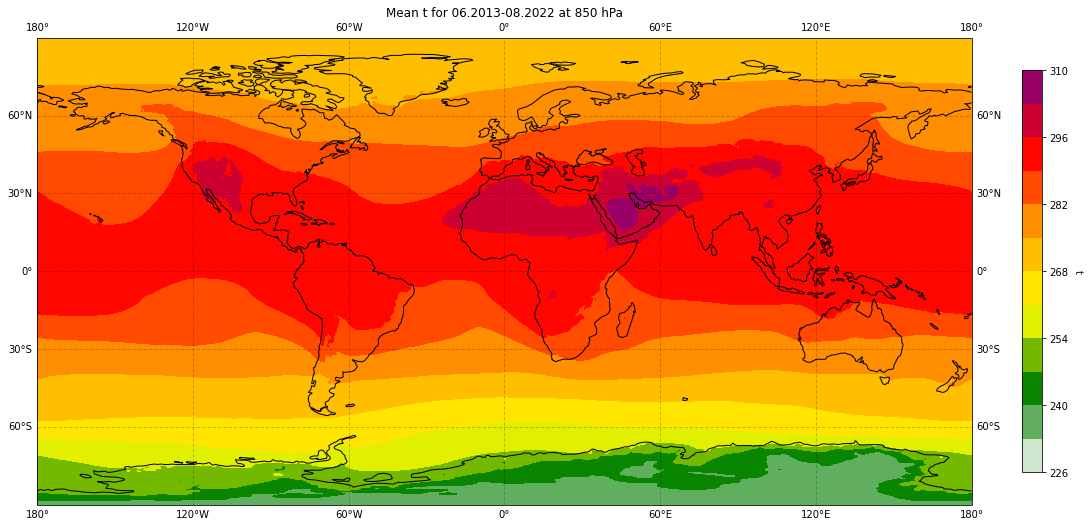

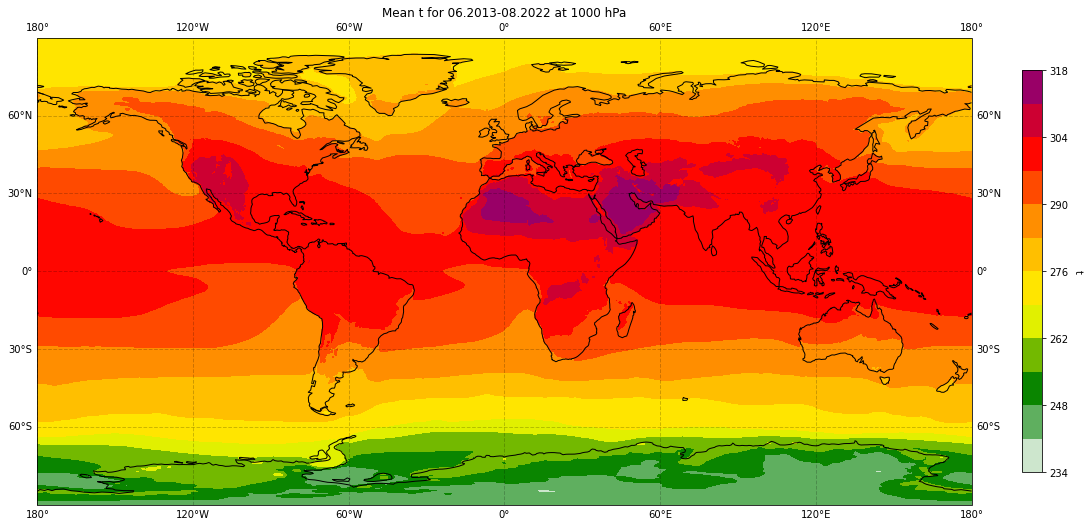

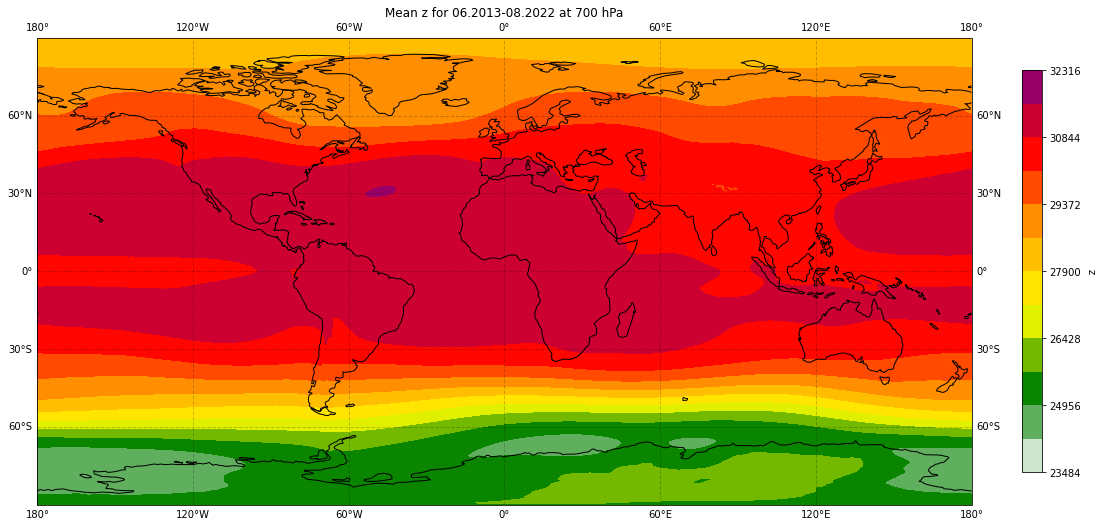

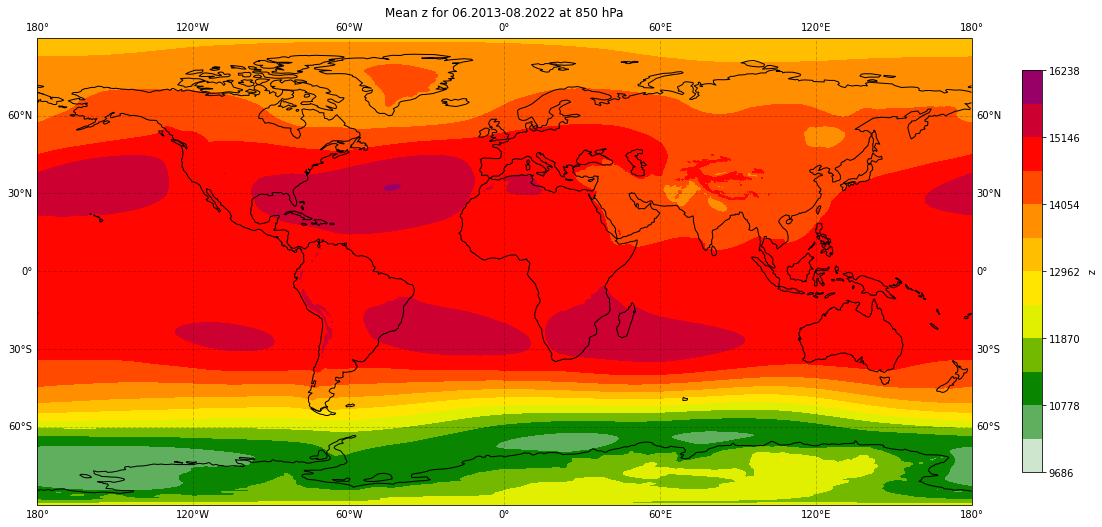

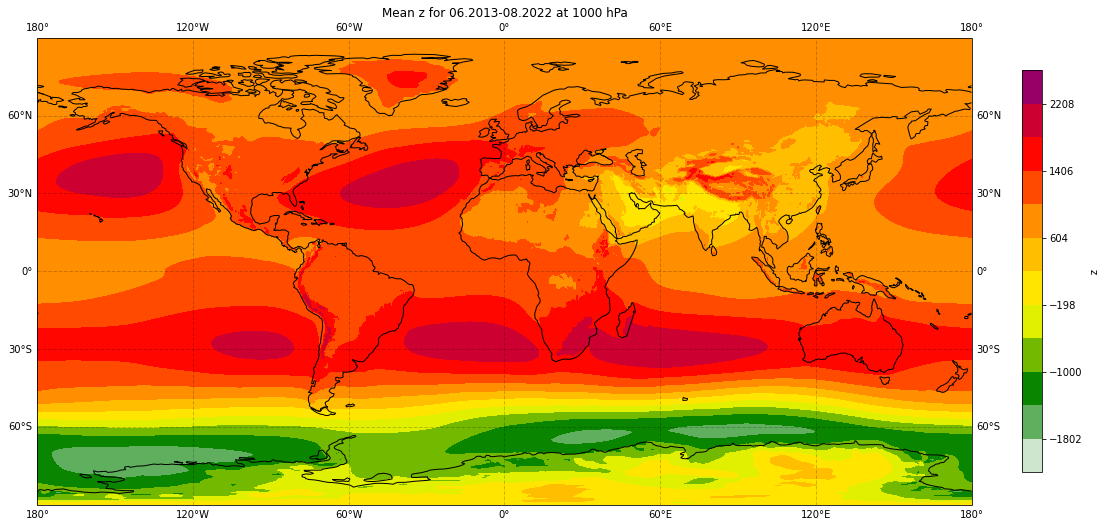

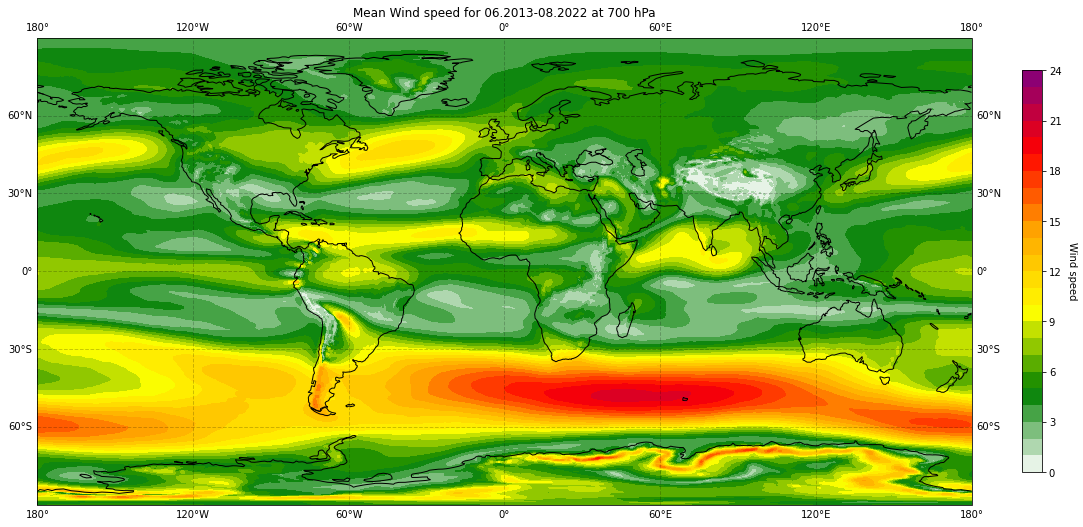

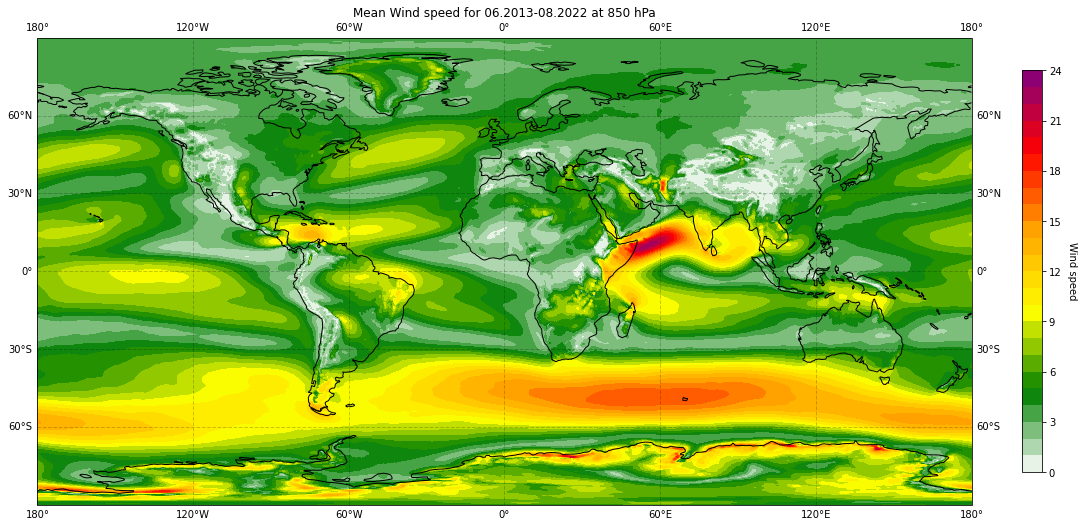

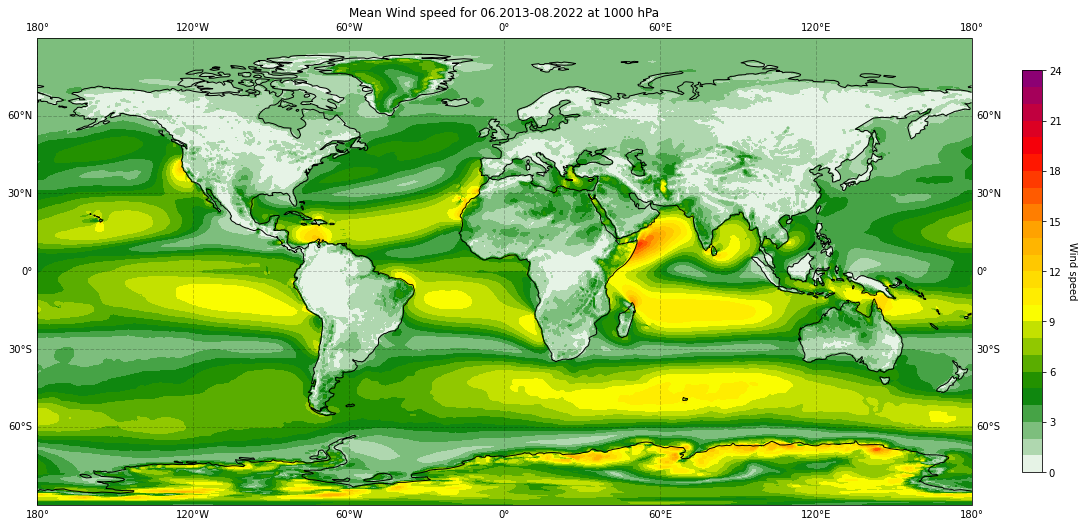

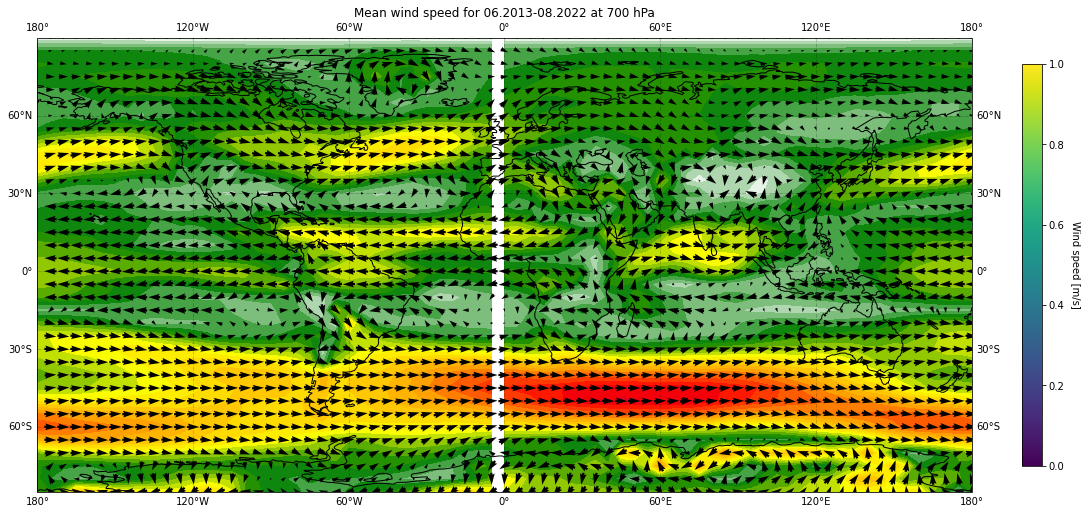

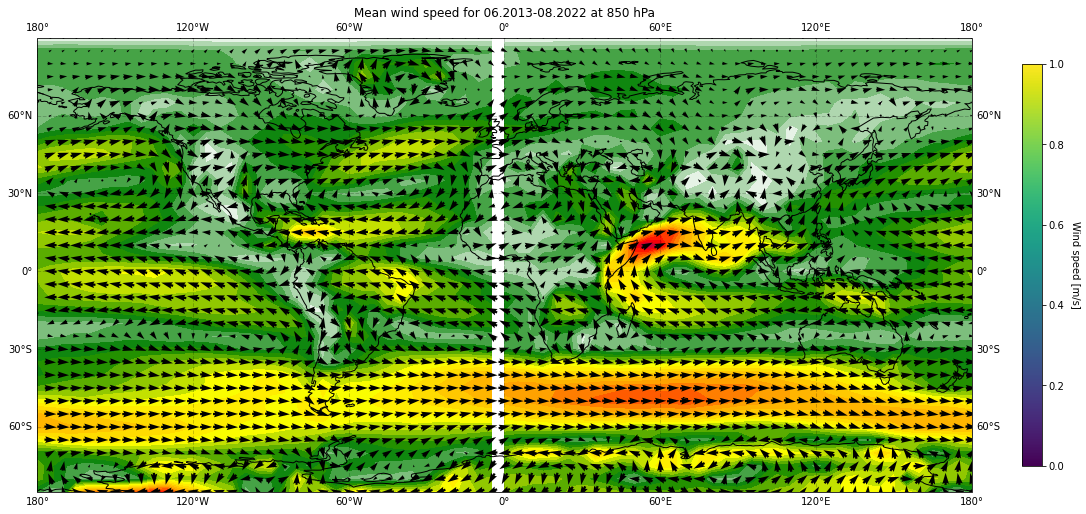

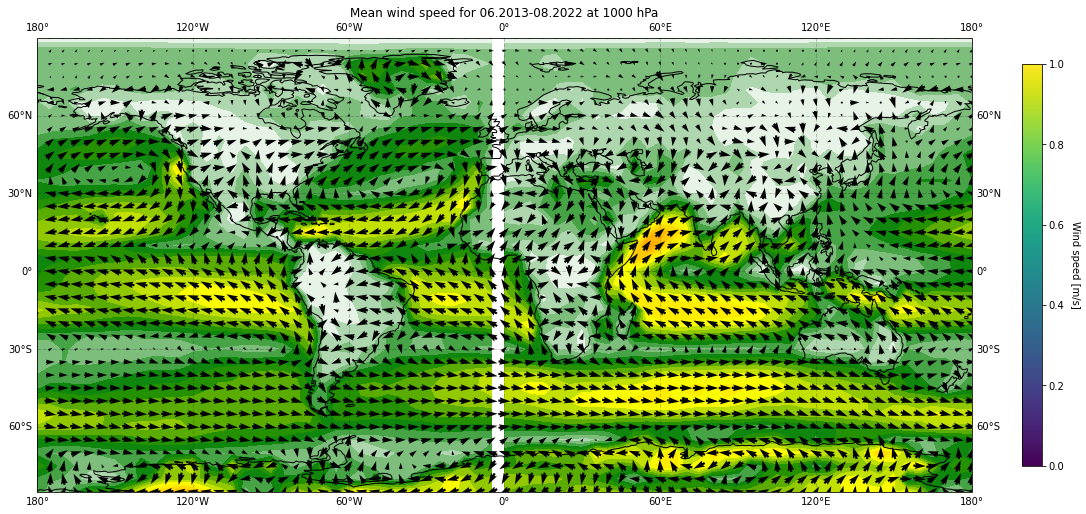

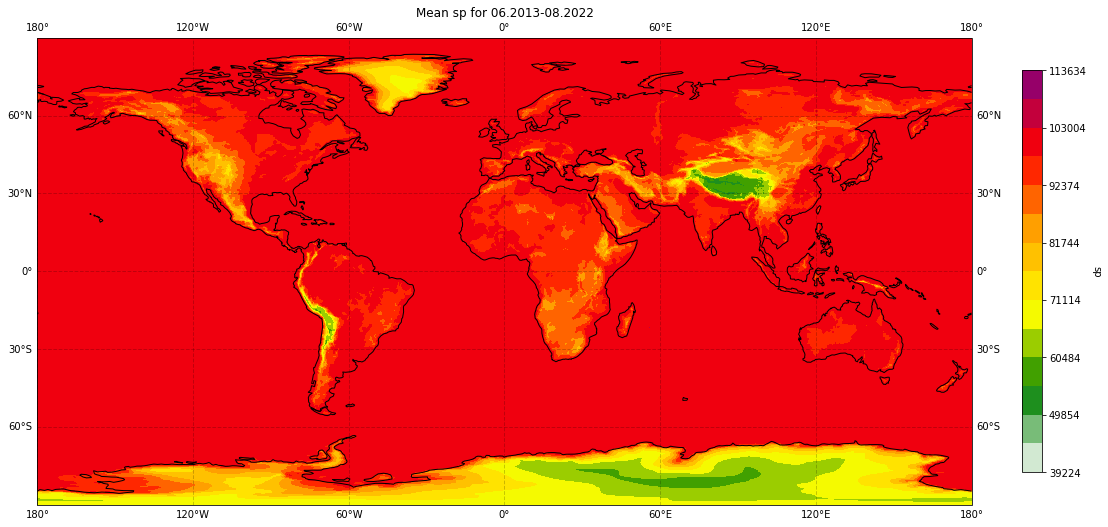

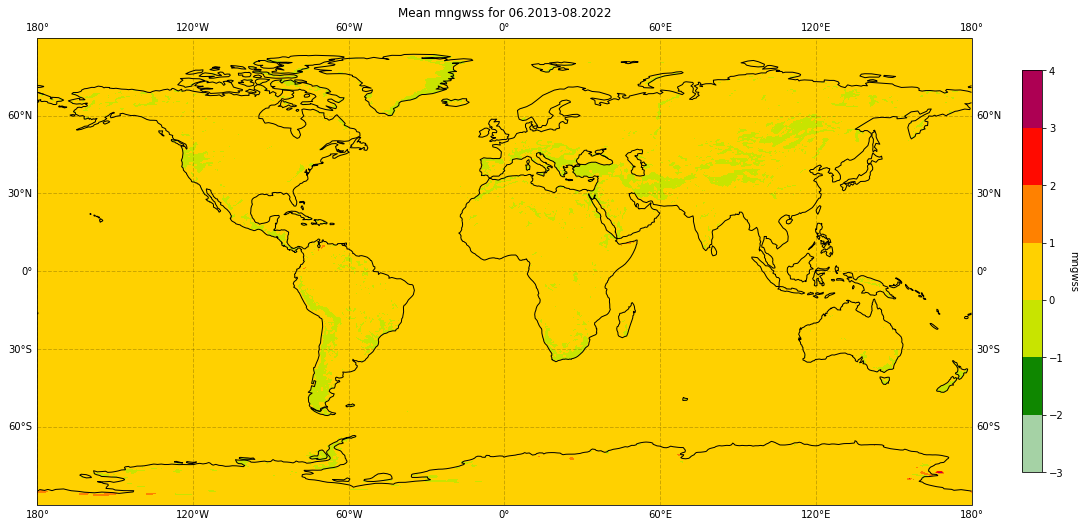

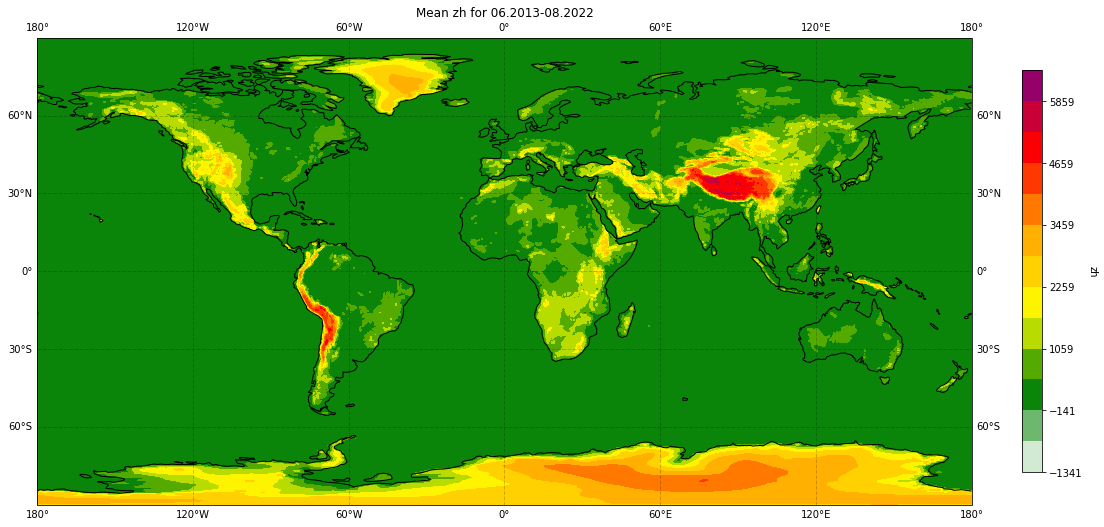

In [43]:
to_plot = True
if to_plot:
    data_windspeed = np.sqrt(data_u ** 2 + data_v ** 2) 
    data_windspeed_summer_mean = np.mean(data_windspeed, axis = 0)
    data_u_mean = np.mean(data_u, axis = 0)
    data_v_mean = np.mean(data_v, axis = 0)
    data_t_mean = np.mean(data_t, axis = 0)
    data_z_mean = np.mean(data_z, axis = 0)

    data_u_mean_norm = data_u_mean / data_windspeed_summer_mean
    data_v_mean_norm = data_v_mean / data_windspeed_summer_mean

    data_sp_mean = np.mean(data_sp, axis = 0)
    data_metss_mean = np.mean(data_metss, axis = 0)
    data_mngwss_mean = np.mean(data_mngwss, axis = 0)
    data_zh_mean = np.mean(data_zh, axis = 0)

    data = zip(
        ['sp', 'mngwss', 'zh'],
        [data_sp_mean, data_mngwss_mean, data_zh_mean])

    # Теперь построим карты средней за лето скорости ветра для каждой из высот (уровней давления)

    data_crs = ccrs.PlateCarree()

    # Можем создать собственную цветовую палитру для карт, выбрав нужные цвета и их порядок
    newcmp = LinearSegmentedColormap.from_list('', ['white', 'green', 'yellow', 'orange', 'red', 'purple'])

    # Создаём цикл, в котором итератор p_i пройдёт по всем уровням давления - будет меняться от 0 
    # до длины массива уровней давления (p_level) невключительно, то есть примет значения 0, 1 и 2. 
    for name, el in zip(['t', 'z', 'Wind speed'], [data_t_mean, data_z_mean, data_windspeed_summer_mean]):
        for p_i in range(len(p_level)):
            f = plt.figure(figsize = (18, 9))
            f.patch.set_facecolor('white')

            if name == 'Wind speed':
                start = 0
                end = 25
                step = 1
            else:
                step = int((el[p_i, :, :].max() - el[p_i, :, :].min()) // 10)
                start = round(el[p_i, :, :].min()) - step
                end = round(el[p_i, :, :].max()) + step

            ax = plt.axes(projection = data_crs)
            # Можем указать границы для рисуемой области карты (но в данном примере нарисуем для всей Земли)
            # ax.set_extent([0, 180, 0, 90], crs = data_crs)

            plt.contourf(lons, lats, el[p_i, :, :], levels = range(start, end, step), transform = data_crs, cmap = newcmp)
            ax.coastlines()

            gl = ax.gridlines(crs = ccrs.PlateCarree(), draw_labels = True,
                              linewidth = 1, color = 'black', alpha = 0.2, linestyle = '--')

            cbar = plt.colorbar(fraction = 0.02)
            cbar.ax.get_yaxis().labelpad = 15
            cbar.set_label(name, rotation = 270)

            delta_epoch = datetime(1970, 1, 1, 0, 0, 0) - datetime(1900, 1, 1, 0, 0, 0)
            date_start = datetime.fromtimestamp(time[0] * 3600) - delta_epoch
            date_end = datetime.fromtimestamp(time[-1] * 3600) - delta_epoch
            plt.title(f'Mean {name} for {date_start.strftime("%m.%Y")}-{date_end.strftime("%m.%Y")} at {p_level[p_i]} hPa')

            plt.show()

    for p_i in range(len(p_level)):
        f = plt.figure(figsize = (18, 9))
        f.patch.set_facecolor('white')

        ax = plt.axes(projection = data_crs)

        start = 0
        end = -1
        step = 20
        plt.contourf(lons[start:end:step], lats[start:end:step], data_windspeed_summer_mean[p_i, start:end:step, start:end:step], levels = range(0, 25, 1), transform = data_crs, cmap = newcmp)
        ax.coastlines()

        plt.quiver(lons[start:end:step], lats[start:end:step], data_u_mean_norm[p_i, start:end:step, start:end:step], data_v_mean_norm[p_i, start:end:step, start:end:step], pivot='middle')
        gl = ax.gridlines(crs = ccrs.PlateCarree(), draw_labels = True,
                          linewidth = 1, color = 'black', alpha = 0.2, linestyle = '--')

        cbar = plt.colorbar(fraction = 0.02)
        cbar.ax.get_yaxis().labelpad = 15
        cbar.set_label('Wind speed [m/s]', rotation = 270)

        delta_epoch = datetime(1970, 1, 1, 0, 0, 0) - datetime(1900, 1, 1, 0, 0, 0)
        date_start = datetime.fromtimestamp(time[0] * 3600) - delta_epoch
        date_end = datetime.fromtimestamp(time[-1] * 3600) - delta_epoch
        plt.title(f'Mean wind speed for {date_start.strftime("%m.%Y")}-{date_end.strftime("%m.%Y")} at {p_level[p_i]} hPa')

        plt.show()

    for name, el in data:
        f = plt.figure(figsize = (18, 9))
        f.patch.set_facecolor('white')


        step = int((el.max() - el.min()) // 10)
        step = 1 if step == 0 else step
        start = round(el.min()) - step
        end = round(el.max()) + step
        if step > 1:
            start -= step
            end += step

        ax = plt.axes(projection = data_crs)
        # Можем указать границы для рисуемой области карты (но в данном примере нарисуем для всей Земли)
        # ax.set_extent([0, 180, 0, 90], crs = data_crs)

        plt.contourf(lons, lats, el, levels=range(start, end, step), transform=data_crs, cmap = newcmp)
        ax.coastlines()

        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                          linewidth=1, color = 'black', alpha=0.2, linestyle='--')

        cbar = plt.colorbar(fraction = 0.02)
        cbar.ax.get_yaxis().labelpad = 15
        cbar.set_label(name, rotation = 270)

        delta_epoch = datetime(1970, 1, 1, 0, 0, 0) - datetime(1900, 1, 1, 0, 0, 0)
        date_start = datetime.fromtimestamp(time[0] * 3600) - delta_epoch
        date_end = datetime.fromtimestamp(time[-1] * 3600) - delta_epoch
        plt.title(f'Mean {name} for {date_start.strftime("%m.%Y")}-{date_end.strftime("%m.%Y")}')

        plt.show()

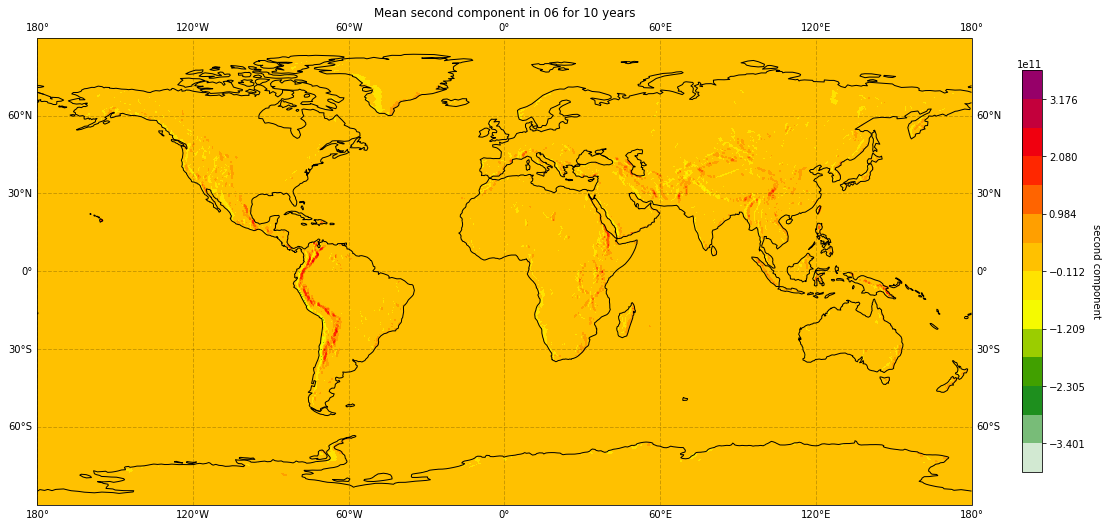

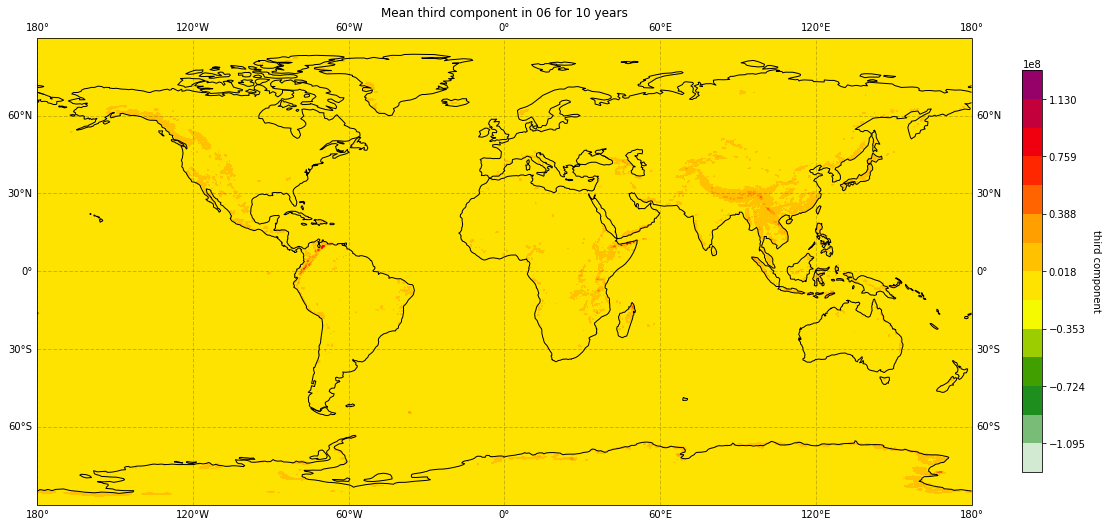

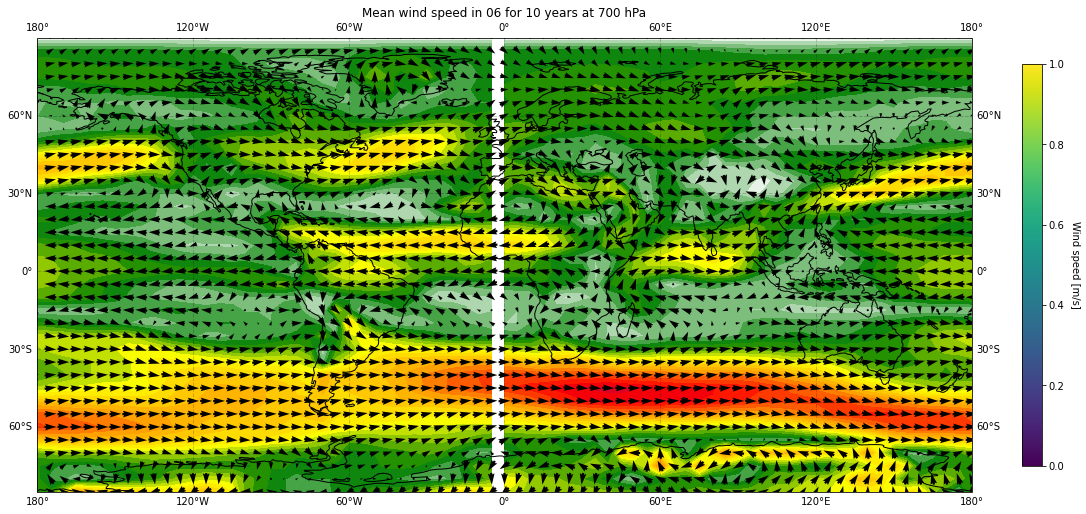

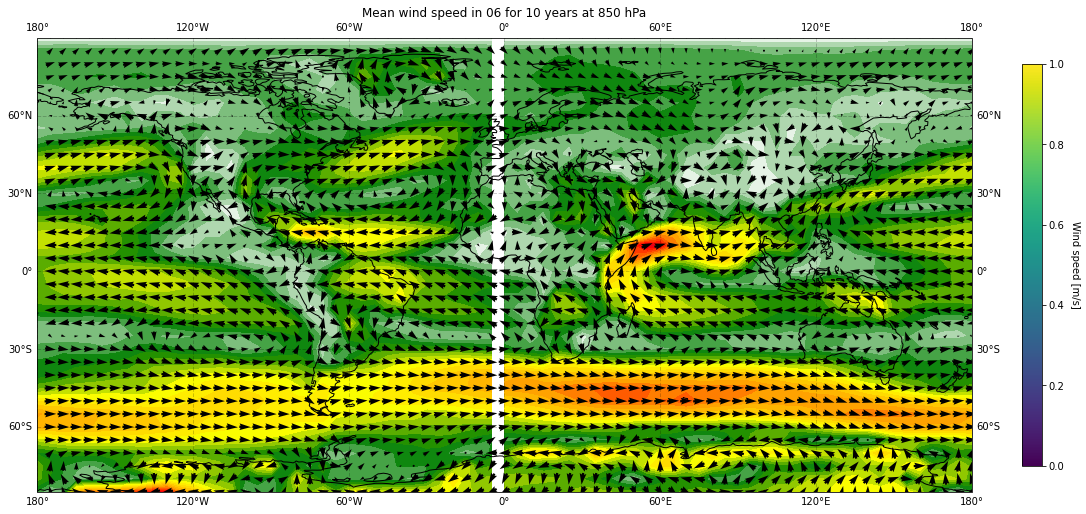

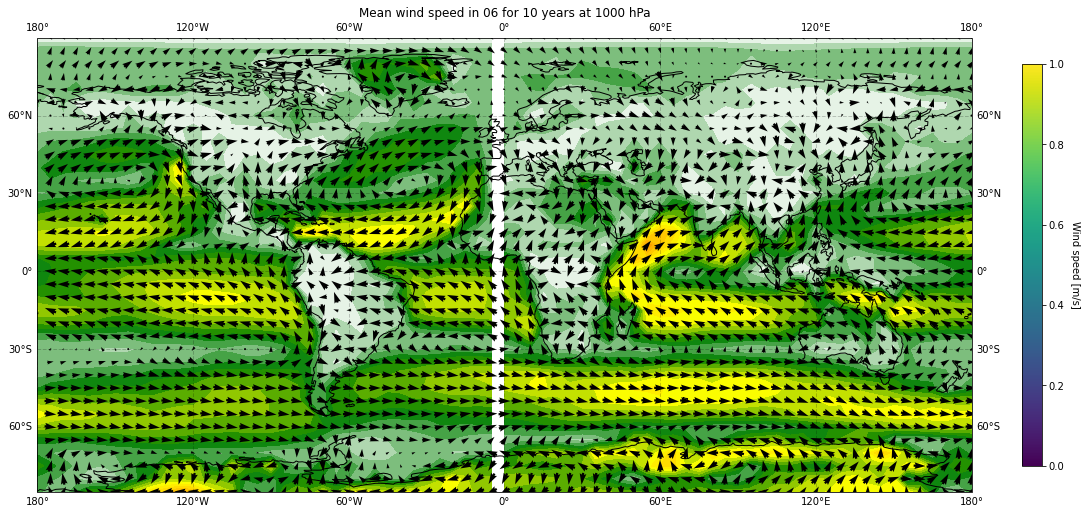

In [44]:
to_plot = True
if to_plot:
    n_month = 0
    third_component_mean_in_month = np.mean(third_component[n_month::3], axis = 0)
    second_component_mean_in_month = np.mean(second_component[n_month::3], axis = 0)
    
    data_windspeed = np.sqrt(data_u ** 2 + data_v ** 2) 
    data_windspeed_mean_in_month = np.mean(data_windspeed[n_month::3], axis = 0)
    
    data_u_mean_in_month = np.mean(data_u[::3], axis = 0)
    data_v_mean_in_month = np.mean(data_v[::3], axis = 0)

    data_u_mean_norm_in_month = data_u_mean_in_month / data_windspeed_mean_in_month
    data_v_mean_norm_in_month = data_v_mean_in_month / data_windspeed_mean_in_month

    

    data = zip(
        ['second component', 'third component'],
        [second_component_mean_in_month, third_component_mean_in_month])

    # Теперь построим карты средней за лето скорости ветра для каждой из высот (уровней давления)

    data_crs = ccrs.PlateCarree()

    # Можем создать собственную цветовую палитру для карт, выбрав нужные цвета и их порядок
    newcmp = LinearSegmentedColormap.from_list('', ['white', 'green', 'yellow', 'orange', 'red', 'purple'])


    for name, el in data:
        f = plt.figure(figsize = (18, 9))
        f.patch.set_facecolor('white')


        step = int((el.max() - el.min()) // 10)
        step = 1 if step == 0 else step
        start = round(el.min()) - step
        end = round(el.max()) + step
        if step > 1:
            start -= step
            end += step

        ax = plt.axes(projection = data_crs)

        plt.contourf(lons, lats, el, levels=range(start, end, step), transform=data_crs, cmap = newcmp)
        ax.coastlines()

        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                          linewidth=1, color = 'black', alpha=0.2, linestyle='--')

        cbar = plt.colorbar(fraction = 0.02)
        cbar.ax.get_yaxis().labelpad = 15
        cbar.set_label(name, rotation = 270)

        delta_epoch = datetime(1970, 1, 1, 0, 0, 0) - datetime(1900, 1, 1, 0, 0, 0)
        date = datetime.fromtimestamp(time[n_month] * 3600) - delta_epoch
        plt.title(f'Mean {name} in {date.strftime("%m")} for 10 years')

        plt.show()
        
    for p_i in range(len(p_level)):
        f = plt.figure(figsize = (18, 9))
        f.patch.set_facecolor('white')

        ax = plt.axes(projection = data_crs)

        start = 0
        end = -1
        step = 20
        plt.contourf(lons[start:end:step], lats[start:end:step],
                     data_windspeed_mean_in_month[p_i, start:end:step, start:end:step],
                     levels = range(0, 25, 1), transform = data_crs, cmap = newcmp)
        ax.coastlines()

        plt.quiver(lons[start:end:step], lats[start:end:step],
                   data_u_mean_norm_in_month[p_i, start:end:step, start:end:step],
                   data_v_mean_norm_in_month[p_i, start:end:step, start:end:step],
                   pivot='middle')
        gl = ax.gridlines(crs = ccrs.PlateCarree(), draw_labels = True,
                          linewidth = 1, color = 'black', alpha = 0.2, linestyle = '--')

        cbar = plt.colorbar(fraction = 0.02)
        cbar.ax.get_yaxis().labelpad = 15
        cbar.set_label('Wind speed [m/s]', rotation = 270)

        delta_epoch = datetime(1970, 1, 1, 0, 0, 0) - datetime(1900, 1, 1, 0, 0, 0)
        date = datetime.fromtimestamp(time[n_month] * 3600) - delta_epoch
        plt.title(f'Mean wind speed in {date.strftime("%m")} for 10 years at {p_level[p_i]} hPa')

        plt.show()